In [1]:
import datetime
import gc
import joblib
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from imblearn.over_sampling import SMOTE
from itertools import repeat
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import (
    RAW_DATA_PATH, PROCESSED_DATA_PATH
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"
EXP_PATH = "../experiments"
DROP_FEATURES_PATH = "../dropped_features"

In [5]:
%load_ext autoreload
%autoreload

### Read Data

In [6]:
%%time
train_agg = read_file(f"{PROCESSED_DATA_PATH}/train_agg_complete2.pkl")

Shape of data: (458913, 4334)
CPU times: user 3.24 s, sys: 8.6 s, total: 11.8 s
Wall time: 16.3 s


In [7]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


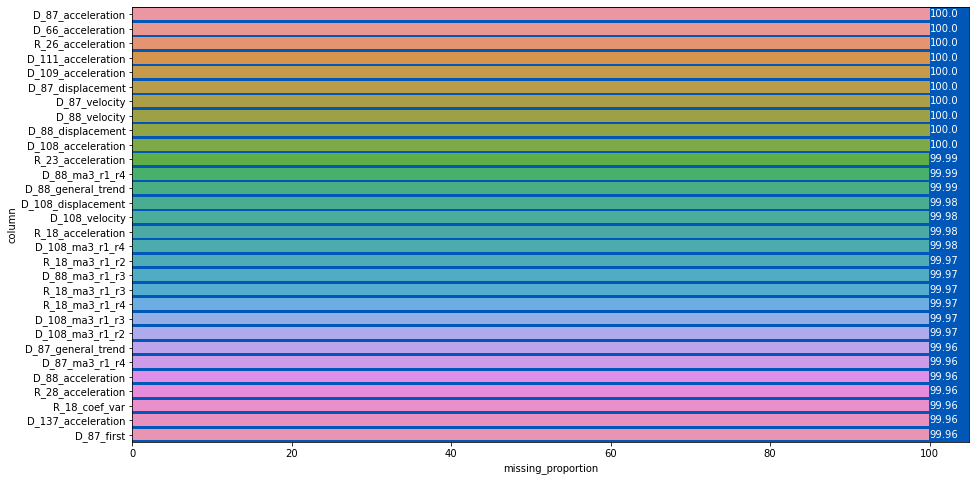

In [8]:
m = plot_missing_proportion_barchart(train_agg)

In [9]:
train_agg.shape

(458913, 4334)

### Pre-train Feature Reduction

In [10]:
def select_noob_features(feature_imp_df, threshold):
    noob_features = []
    for type_ in feature_imp_df.columns[1:]:
        noob_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    print(len(noob_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return noob_features

In [11]:
def get_feature_imp_percentile(summary_df, p):
    array = pd.Series(np.stack(summary_df.drop(columns="base_feature", errors="ignore").values).ravel()).dropna().values
    return np.percentile(array, p)

In [50]:
features_to_drop = set()
for i, threshold_percentile in zip(range(3), [70, 45, 40]):
    print(f"Read file {i}")
    summary_feature_imp = read_file(f"{EXP_PATH}/feature_imp_summary{i}.csv")
    feature_imp_thr = get_feature_imp_percentile(summary_feature_imp, threshold_percentile)
    drop_feature_subset = set(select_noob_features(summary_feature_imp, feature_imp_thr))
    features_to_drop = features_to_drop.union(drop_feature_subset)
    print(f"Threshold = {feature_imp_thr:.2f}, Dropping # of features {len(drop_feature_subset)}")

Read file 0
Shape of data: (181, 49)
3050 8688
Threshold = 43.20, Dropping # of features 3050
Read file 1
Shape of data: (176, 25)
1214 4224
Threshold = 46.84, Dropping # of features 1214
Read file 2
Shape of data: (188, 25)
1536 4512
Threshold = 6.80, Dropping # of features 1536


In [51]:
len(features_to_drop)

4980

In [52]:
train_agg = train_agg.drop(columns=list(features_to_drop), errors="ignore")

In [53]:
target = labels["target"].values

In [54]:
%%time
train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore")
gc.collect()

CPU times: user 167 ms, sys: 581 ms, total: 748 ms
Wall time: 747 ms


72

In [55]:
cat_columns = train_agg.select_dtypes("category").columns.to_list()

In [56]:
train_agg.shape, target.shape

((458913, 1192), (458913,))

### Oversampling / Undersampling (SMOTE)

In [57]:
# sm = SMOTE(random_state=923)
# X_res, y_res = sm.fit_resample(train_agg, target)
# X_res.shape, y_res.shape

In [58]:
# train_missing_prop_df = plot_missing_proportion_barchart(train, top_n=50)

In [59]:
# train_missing_prop_df = plot_missing_proportion_barchart(train, top_n=40)

In [60]:
# train_analysis = single_col_target_check(train, "R_13", q=10)

In [61]:
# train_agg_analysis = single_col_target_check(train_agg, "S_6_last", q=10)

In [62]:
# train_agg_analysis.head()

In [63]:
# selected_features = pd.read_csv("top_features.csv")
# selected_features = selected_features["feature"].tolist()

In [64]:
# train_agg = train_agg.loc[:, selected_features]

In [65]:
# missing_count_df = plot_missing_proportion_barchart(train_agg)

In [66]:
# high_missing_columns = missing_count_df.loc[missing_count_df["missing_proportion"] > 75, "column"].tolist()

In [67]:
# print("Pre feature drop", train.shape)
# train_agg = train_agg.loc[:, set(feature_list).intersection(set(train_agg.columns))]
# train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")
# print("Post feature drop", train.shape)

### Tune LGBM using Optuna (KFold)

In [68]:
CURRENT_EXP_PATH = f"{EXP_PATH}/lgbm_gbdt_exp"
CURRENT_EXP_PATH

'../experiments/lgbm_gbdt_exp'

In [69]:
with open(f"{CURRENT_EXP_PATH}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

0.7955832525034824

In [73]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5) # , shuffle=True, random_state=1020
    params = {
        "objective": "binary",
        "metrics": "custom",
        "first_metric_only": True, 
        "boost_from_average": False,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "learning_rate": 0.022,
        "n_estimators": 7500,
        "max_bins": 255,
        "subsample_freq": 2,
        "min_child_samples": 2000,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 0.2, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 10, 50, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.19, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 0.75),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.5, 2.5),
        "num_leaves": trial.suggest_int("num_leaves", 75, 125)
    }
    print(
        "alpha", round(params["reg_alpha"], 4), 
        "lambda", round(params["reg_lambda"], 4),
        "colsample_bytree", round(params["colsample_bytree"], 3),
        "subsample", round(params["subsample"], 3), 
        "scale_pos_weight", round(params["scale_pos_weight"], 3), 
        "num_leaves", round(params["num_leaves"], 0)
    )
    train_score_list, val_score_list = [], []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
        fold = str(fold)
        X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
        train_data = lgb.Dataset(
            X_train,
            y_train
        )
        X_val, y_val = train_agg.iloc[idx_va], target[idx_va], 
        valid_data = lgb.Dataset(
            X_val,
            y_val,
            reference=train_data
        )
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model = lgb.train(
                params=params,
                train_set=train_data, 
                valid_sets=[valid_data, train_data], 
                feval=lgb_amex_metric, 
                early_stopping_rounds=250,
                categorical_feature=cat_columns,
                callbacks=[
                    log_evaluation(100),
                ]
            )
        y_train_pred = model.predict(X_train, raw_score=True)
        train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
        train_data, X_train, y_train = None, None, None
        y_val_pred = model.predict(X_val, raw_score=True)
        val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
        valid_data, X_val, y_val = None, None, None
        train_score_list.append(train_score)
        val_score_list.append(val_score)
        if val_score > best_scores_json["validation"][fold]:
            best_scores_json["train"][fold] = train_score
            best_scores_json["validation"][fold] = val_score
            with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
                json.dump(best_scores_json, outfile)
            joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
        elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.02:
            print(f"Train score too high (overfitting), start a new trial")
            return np.mean(val_score_list)
        print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")
        print(f"Clear cache {gc.collect()}")
        
    return np.mean(val_score_list)

In [74]:
# study = joblib.load(f"{CURRENT_EXP_PATH}/optuna_study.pkl")

In [75]:
study = optuna.create_study(direction="maximize")

[I 2022-07-23 09:27:49,097] A new study created in memory with name: no-name-c650d067-4da7-41ca-b551-83e28873aaaf


In [76]:
study.optimize(objective, n_trials=25)

alpha 0.142 lambda 13.8791 colsample_bytree 0.236 subsample 0.721 scale_pos_weight 1.81 num_leaves 89
[100]	training's amex: 0.768002	valid_0's amex: 0.76055
[200]	training's amex: 0.787432	valid_0's amex: 0.776589
[300]	training's amex: 0.801677	valid_0's amex: 0.782908
[400]	training's amex: 0.813492	valid_0's amex: 0.786889
[500]	training's amex: 0.822602	valid_0's amex: 0.79047
[600]	training's amex: 0.831137	valid_0's amex: 0.791856
[700]	training's amex: 0.839705	valid_0's amex: 0.79268
[800]	training's amex: 0.848124	valid_0's amex: 0.793302
[900]	training's amex: 0.856168	valid_0's amex: 0.793491
[1000]	training's amex: 0.863909	valid_0's amex: 0.793903
[1100]	training's amex: 0.87173	valid_0's amex: 0.793784
[1200]	training's amex: 0.879484	valid_0's amex: 0.793931
Fold 1 | Train Score = 0.86800 (0.9583, 0.7777)
Fold 1 | Val Score = 0.79431 (0.9229, 0.6657)
Clear cache 14
[100]	training's amex: 0.767544	valid_0's amex: 0.758619
[200]	training's amex: 0.787401	valid_0's amex: 0

[I 2022-07-23 10:02:21,439] Trial 0 finished with value: 0.7952085044600888 and parameters: {'reg_alpha': 0.14195949395754148, 'reg_lambda': 13.87907855038194, 'colsample_bytree': 0.23573096890297715, 'subsample': 0.7209649295061002, 'scale_pos_weight': 1.8103000600095478, 'num_leaves': 89}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.87930 (0.9624, 0.7962)
Fold 5 | Val Score = 0.79705 (0.9253, 0.6688)
Clear cache 380
alpha 0.0043 lambda 13.368 colsample_bytree 0.202 subsample 0.579 scale_pos_weight 2.374 num_leaves 102
[100]	training's amex: 0.763201	valid_0's amex: 0.757049
[200]	training's amex: 0.782807	valid_0's amex: 0.77422
[300]	training's amex: 0.797098	valid_0's amex: 0.783115
[400]	training's amex: 0.807319	valid_0's amex: 0.787494
[500]	training's amex: 0.815384	valid_0's amex: 0.789552
[600]	training's amex: 0.822882	valid_0's amex: 0.791009
[700]	training's amex: 0.829532	valid_0's amex: 0.791864
[800]	training's amex: 0.836178	valid_0's amex: 0.792099
[900]	training's amex: 0.84285	valid_0's amex: 0.792367
[1000]	training's amex: 0.849677	valid_0's amex: 0.792625
[1100]	training's amex: 0.856396	valid_0's amex: 0.792399
[1200]	training's amex: 0.862751	valid_0's amex: 0.792517
[1300]	training's amex: 0.869049	valid_0's amex: 0.792985
[1400]	training's amex: 0.874833	valid_0's 

[I 2022-07-23 10:35:34,525] Trial 1 finished with value: 0.7948507507224912 and parameters: {'reg_alpha': 0.004344875208095323, 'reg_lambda': 13.367970202963486, 'colsample_bytree': 0.2015068223935415, 'subsample': 0.5792140288496583, 'scale_pos_weight': 2.3742522127674013, 'num_leaves': 102}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.83366 (0.9449, 0.7224)
Fold 5 | Val Score = 0.79456 (0.9247, 0.6644)
Clear cache 132
alpha 0.0068 lambda 16.3214 colsample_bytree 0.293 subsample 0.518 scale_pos_weight 1.769 num_leaves 86
[100]	training's amex: 0.762712	valid_0's amex: 0.75663
[200]	training's amex: 0.781934	valid_0's amex: 0.774284
[300]	training's amex: 0.795349	valid_0's amex: 0.782222
[400]	training's amex: 0.805168	valid_0's amex: 0.785783
[500]	training's amex: 0.813669	valid_0's amex: 0.788004
[600]	training's amex: 0.820821	valid_0's amex: 0.789767
[700]	training's amex: 0.828072	valid_0's amex: 0.79031
[800]	training's amex: 0.835304	valid_0's amex: 0.791779
[900]	training's amex: 0.841273	valid_0's amex: 0.791415
[1000]	training's amex: 0.848214	valid_0's amex: 0.791978
[1100]	training's amex: 0.854451	valid_0's amex: 0.79209
[1200]	training's amex: 0.860765	valid_0's amex: 0.792641
[1300]	training's amex: 0.866917	valid_0's amex: 0.792821
[1400]	training's amex: 0.873399	valid_0's a

[I 2022-07-23 11:11:20,784] Trial 2 finished with value: 0.7941647404657786 and parameters: {'reg_alpha': 0.00682619040553603, 'reg_lambda': 16.321403614788384, 'colsample_bytree': 0.29268864791666566, 'subsample': 0.517669353938456, 'scale_pos_weight': 1.7687349931699574, 'num_leaves': 86}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.86871 (0.9582, 0.7792)
Fold 5 | Val Score = 0.79681 (0.9251, 0.6685)
Clear cache 62
alpha 0.0137 lambda 11.7739 colsample_bytree 0.206 subsample 0.654 scale_pos_weight 2.365 num_leaves 125
[100]	training's amex: 0.764747	valid_0's amex: 0.759451
[200]	training's amex: 0.784616	valid_0's amex: 0.775833
[300]	training's amex: 0.799183	valid_0's amex: 0.781822
[400]	training's amex: 0.810142	valid_0's amex: 0.787
[500]	training's amex: 0.819263	valid_0's amex: 0.789733
[600]	training's amex: 0.827637	valid_0's amex: 0.791632
[700]	training's amex: 0.835259	valid_0's amex: 0.791935
[800]	training's amex: 0.8431	valid_0's amex: 0.79251
[900]	training's amex: 0.851056	valid_0's amex: 0.792631
[1000]	training's amex: 0.858044	valid_0's amex: 0.792423
[1100]	training's amex: 0.865463	valid_0's amex: 0.792815
[1200]	training's amex: 0.872648	valid_0's amex: 0.792682
[1300]	training's amex: 0.879617	valid_0's amex: 0.792842
[1400]	training's amex: 0.886751	valid_0's amex

[I 2022-07-23 11:44:18,582] Trial 3 finished with value: 0.7947849270640877 and parameters: {'reg_alpha': 0.013735943387196206, 'reg_lambda': 11.773907579038443, 'colsample_bytree': 0.20591222401921264, 'subsample': 0.6535906090218637, 'scale_pos_weight': 2.3648598908515357, 'num_leaves': 125}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.82949 (0.9428, 0.7162)
Fold 5 | Val Score = 0.79505 (0.9243, 0.6658)
Clear cache 370
alpha 0.0046 lambda 28.9785 colsample_bytree 0.286 subsample 0.533 scale_pos_weight 2.063 num_leaves 113
[100]	training's amex: 0.761444	valid_0's amex: 0.756014
[200]	training's amex: 0.78141	valid_0's amex: 0.77454
[300]	training's amex: 0.794781	valid_0's amex: 0.781001
[400]	training's amex: 0.804794	valid_0's amex: 0.785889
[500]	training's amex: 0.812371	valid_0's amex: 0.788406
[600]	training's amex: 0.819595	valid_0's amex: 0.790278
[700]	training's amex: 0.826395	valid_0's amex: 0.790462
[800]	training's amex: 0.832841	valid_0's amex: 0.790333
[900]	training's amex: 0.838439	valid_0's amex: 0.791262
[1000]	training's amex: 0.844922	valid_0's amex: 0.792056
[1100]	training's amex: 0.85101	valid_0's amex: 0.791943
[1200]	training's amex: 0.85678	valid_0's amex: 0.792484
[1300]	training's amex: 0.862908	valid_0's amex: 0.792737
[1400]	training's amex: 0.869353	valid_0's a

[I 2022-07-23 12:20:57,433] Trial 4 finished with value: 0.7945693962572338 and parameters: {'reg_alpha': 0.004561843324945278, 'reg_lambda': 28.97846402858729, 'colsample_bytree': 0.2862883530798857, 'subsample': 0.5328527199528147, 'scale_pos_weight': 2.062590043199485, 'num_leaves': 113}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.84290 (0.9482, 0.7376)
Fold 5 | Val Score = 0.79687 (0.9250, 0.6688)
Clear cache 146
alpha 0.0247 lambda 24.8331 colsample_bytree 0.215 subsample 0.58 scale_pos_weight 1.611 num_leaves 85
[100]	training's amex: 0.763307	valid_0's amex: 0.757896
[200]	training's amex: 0.782223	valid_0's amex: 0.772897
[300]	training's amex: 0.796568	valid_0's amex: 0.781668
[400]	training's amex: 0.806858	valid_0's amex: 0.786136
[500]	training's amex: 0.815187	valid_0's amex: 0.787867
[600]	training's amex: 0.822889	valid_0's amex: 0.789965
[700]	training's amex: 0.829943	valid_0's amex: 0.791375
[800]	training's amex: 0.836885	valid_0's amex: 0.792368
[900]	training's amex: 0.843627	valid_0's amex: 0.79256
[1000]	training's amex: 0.850511	valid_0's amex: 0.791386
[1100]	training's amex: 0.857509	valid_0's amex: 0.792898
[1200]	training's amex: 0.86391	valid_0's amex: 0.792716
[1300]	training's amex: 0.870364	valid_0's amex: 0.792939
[1400]	training's amex: 0.876794	valid_0's a

[I 2022-07-23 12:57:20,919] Trial 5 finished with value: 0.7950933487679958 and parameters: {'reg_alpha': 0.024673524959861647, 'reg_lambda': 24.83313476698991, 'colsample_bytree': 0.21450030795596026, 'subsample': 0.5803171852926325, 'scale_pos_weight': 1.6106469264772851, 'num_leaves': 85}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.88577 (0.9639, 0.8076)
Fold 5 | Val Score = 0.79715 (0.9253, 0.6690)
Clear cache 172
alpha 0.004 lambda 15.3616 colsample_bytree 0.288 subsample 0.574 scale_pos_weight 1.747 num_leaves 87
[100]	training's amex: 0.764517	valid_0's amex: 0.758766
[200]	training's amex: 0.783273	valid_0's amex: 0.774545
[300]	training's amex: 0.797446	valid_0's amex: 0.781992
[400]	training's amex: 0.808416	valid_0's amex: 0.786469
[500]	training's amex: 0.817394	valid_0's amex: 0.788423
[600]	training's amex: 0.825256	valid_0's amex: 0.790768
[700]	training's amex: 0.832682	valid_0's amex: 0.791839
[800]	training's amex: 0.84014	valid_0's amex: 0.792269
[900]	training's amex: 0.847649	valid_0's amex: 0.791807
[1000]	training's amex: 0.855093	valid_0's amex: 0.79315
[1100]	training's amex: 0.862168	valid_0's amex: 0.791887
[1200]	training's amex: 0.869264	valid_0's amex: 0.79245
Fold 1 | Train Score = 0.85669 (0.9537, 0.7596)
Fold 1 | Val Score = 0.79291 (0.9225, 0.6633)
Clear cac

[I 2022-07-23 13:33:24,908] Trial 6 finished with value: 0.7946046446904111 and parameters: {'reg_alpha': 0.003956261404348788, 'reg_lambda': 15.361582230447409, 'colsample_bytree': 0.2881080603651867, 'subsample': 0.5744499164596265, 'scale_pos_weight': 1.7472675568959946, 'num_leaves': 87}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.86923 (0.9587, 0.7798)
Fold 5 | Val Score = 0.79682 (0.9253, 0.6684)
Clear cache 406
alpha 0.0906 lambda 23.2388 colsample_bytree 0.24 subsample 0.67 scale_pos_weight 2.214 num_leaves 91
[100]	training's amex: 0.76486	valid_0's amex: 0.758656
[200]	training's amex: 0.784486	valid_0's amex: 0.775373
[300]	training's amex: 0.79897	valid_0's amex: 0.78361
[400]	training's amex: 0.809585	valid_0's amex: 0.787436
[500]	training's amex: 0.819161	valid_0's amex: 0.789376
[600]	training's amex: 0.827116	valid_0's amex: 0.790933
[700]	training's amex: 0.834823	valid_0's amex: 0.79156
[800]	training's amex: 0.842661	valid_0's amex: 0.792644
[900]	training's amex: 0.849972	valid_0's amex: 0.792668
[1000]	training's amex: 0.857163	valid_0's amex: 0.793016
Fold 1 | Train Score = 0.84787 (0.9510, 0.7447)
Fold 1 | Val Score = 0.79332 (0.9225, 0.6641)
Clear cache 16
[100]	training's amex: 0.765272	valid_0's amex: 0.756478
[200]	training's amex: 0.785428	valid_0's amex: 0.77238

[I 2022-07-23 14:07:45,064] Trial 7 finished with value: 0.794781581802604 and parameters: {'reg_alpha': 0.09064779843182409, 'reg_lambda': 23.238802372290184, 'colsample_bytree': 0.2399693344584639, 'subsample': 0.67032329788918, 'scale_pos_weight': 2.2143401491534527, 'num_leaves': 91}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.83616 (0.9455, 0.7268)
Fold 5 | Val Score = 0.79612 (0.9247, 0.6675)
Clear cache 12
alpha 0.0019 lambda 26.293 colsample_bytree 0.258 subsample 0.508 scale_pos_weight 1.593 num_leaves 78
[100]	training's amex: 0.762207	valid_0's amex: 0.756702
[200]	training's amex: 0.7809	valid_0's amex: 0.77323
[300]	training's amex: 0.793991	valid_0's amex: 0.781333
[400]	training's amex: 0.803712	valid_0's amex: 0.786247
[500]	training's amex: 0.811843	valid_0's amex: 0.788127
[600]	training's amex: 0.819585	valid_0's amex: 0.790437
[700]	training's amex: 0.825945	valid_0's amex: 0.791287
[800]	training's amex: 0.831931	valid_0's amex: 0.791892
[900]	training's amex: 0.838181	valid_0's amex: 0.792329
[1000]	training's amex: 0.844235	valid_0's amex: 0.792594
[1100]	training's amex: 0.850409	valid_0's amex: 0.792704
[1200]	training's amex: 0.856383	valid_0's amex: 0.791958
Fold 1 | Train Score = 0.84441 (0.9482, 0.7407)
Fold 1 | Val Score = 0.79304 (0.9223, 0.6638)
Clear cach

[I 2022-07-23 14:43:15,564] Trial 8 finished with value: 0.794199122948363 and parameters: {'reg_alpha': 0.0019031909190948342, 'reg_lambda': 26.293033759591466, 'colsample_bytree': 0.25841822696595285, 'subsample': 0.5078566497557158, 'scale_pos_weight': 1.5927608661531523, 'num_leaves': 78}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.88120 (0.9624, 0.8000)
Fold 5 | Val Score = 0.79690 (0.9252, 0.6686)
Clear cache 10
alpha 0.004 lambda 32.9865 colsample_bytree 0.202 subsample 0.577 scale_pos_weight 2.255 num_leaves 117
[100]	training's amex: 0.761742	valid_0's amex: 0.756204
[200]	training's amex: 0.781468	valid_0's amex: 0.774111
[300]	training's amex: 0.795281	valid_0's amex: 0.781753
[400]	training's amex: 0.804759	valid_0's amex: 0.785085
[500]	training's amex: 0.812848	valid_0's amex: 0.788011
[600]	training's amex: 0.819943	valid_0's amex: 0.790112
[700]	training's amex: 0.826686	valid_0's amex: 0.791566
[800]	training's amex: 0.832773	valid_0's amex: 0.792864
[900]	training's amex: 0.83926	valid_0's amex: 0.792428
[1000]	training's amex: 0.845749	valid_0's amex: 0.792705
[1100]	training's amex: 0.851183	valid_0's amex: 0.792712
[1200]	training's amex: 0.857502	valid_0's amex: 0.792
Fold 1 | Train Score = 0.84865 (0.9513, 0.7460)
Fold 1 | Val Score = 0.79287 (0.9224, 0.6633)
Clear cach

[I 2022-07-23 15:12:39,722] Trial 9 finished with value: 0.7938940945547931 and parameters: {'reg_alpha': 0.004029206444037598, 'reg_lambda': 32.986504565621644, 'colsample_bytree': 0.20166245200864277, 'subsample': 0.576872571006921, 'scale_pos_weight': 2.25461477553871, 'num_leaves': 117}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.84241 (0.9483, 0.7365)
Fold 5 | Val Score = 0.79594 (0.9249, 0.6669)
Clear cache 106
alpha 0.1906 lambda 43.4193 colsample_bytree 0.235 subsample 0.74 scale_pos_weight 1.901 num_leaves 100
[100]	training's amex: 0.765656	valid_0's amex: 0.758391
[200]	training's amex: 0.784941	valid_0's amex: 0.774688
[300]	training's amex: 0.799801	valid_0's amex: 0.782341
[400]	training's amex: 0.810352	valid_0's amex: 0.786083
[500]	training's amex: 0.819828	valid_0's amex: 0.788586
[600]	training's amex: 0.828312	valid_0's amex: 0.789956
[700]	training's amex: 0.836457	valid_0's amex: 0.791001
[800]	training's amex: 0.84431	valid_0's amex: 0.791701
[900]	training's amex: 0.852232	valid_0's amex: 0.792155
[1000]	training's amex: 0.860112	valid_0's amex: 0.792398
[1100]	training's amex: 0.867229	valid_0's amex: 0.792902
[1200]	training's amex: 0.874859	valid_0's amex: 0.792473
[1300]	training's amex: 0.882022	valid_0's amex: 0.792374
Fold 1 | Train Score = 0.87198 (0.9601, 0.

[I 2022-07-23 15:53:21,174] Trial 10 finished with value: 0.7948044258729209 and parameters: {'reg_alpha': 0.19059460392332186, 'reg_lambda': 43.419289343981696, 'colsample_bytree': 0.23491110563801806, 'subsample': 0.7401012506848796, 'scale_pos_weight': 1.9005989811845994, 'num_leaves': 100}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.88191 (0.9634, 0.8004)
Fold 5 | Val Score = 0.79630 (0.9253, 0.6673)
Clear cache 18
alpha 0.0429 lambda 19.2216 colsample_bytree 0.225 subsample 0.732 scale_pos_weight 1.502 num_leaves 76
[100]	training's amex: 0.767761	valid_0's amex: 0.759449
[200]	training's amex: 0.787043	valid_0's amex: 0.775117
[300]	training's amex: 0.800839	valid_0's amex: 0.782944
[400]	training's amex: 0.811857	valid_0's amex: 0.787428
[500]	training's amex: 0.820655	valid_0's amex: 0.79013
[600]	training's amex: 0.828449	valid_0's amex: 0.792756
[700]	training's amex: 0.836603	valid_0's amex: 0.792958
[800]	training's amex: 0.843954	valid_0's amex: 0.79389
[900]	training's amex: 0.851263	valid_0's amex: 0.792955
[1000]	training's amex: 0.858384	valid_0's amex: 0.793148
Fold 1 | Train Score = 0.84530 (0.9479, 0.7427)
Fold 1 | Val Score = 0.79400 (0.9224, 0.6656)
Clear cache 358
[100]	training's amex: 0.767402	valid_0's amex: 0.758758
[200]	training's amex: 0.787392	valid_0's amex: 0.7

[I 2022-07-23 16:29:06,034] Trial 11 finished with value: 0.79497393188621 and parameters: {'reg_alpha': 0.04292312830446852, 'reg_lambda': 19.221577728163155, 'colsample_bytree': 0.22512502360046172, 'subsample': 0.7323553383428499, 'scale_pos_weight': 1.5017473274015127, 'num_leaves': 76}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.85550 (0.9519, 0.7591)
Fold 5 | Val Score = 0.79656 (0.9251, 0.6680)
Clear cache 174
alpha 0.034 lambda 19.4799 colsample_bytree 0.259 subsample 0.68 scale_pos_weight 1.706 num_leaves 97
[100]	training's amex: 0.765936	valid_0's amex: 0.759358
[200]	training's amex: 0.786004	valid_0's amex: 0.77548
[300]	training's amex: 0.800221	valid_0's amex: 0.783308
[400]	training's amex: 0.811943	valid_0's amex: 0.787511
[500]	training's amex: 0.821396	valid_0's amex: 0.789906
[600]	training's amex: 0.830489	valid_0's amex: 0.790335
[700]	training's amex: 0.83872	valid_0's amex: 0.791518
[800]	training's amex: 0.847144	valid_0's amex: 0.792107
[900]	training's amex: 0.855588	valid_0's amex: 0.792635
[1000]	training's amex: 0.86378	valid_0's amex: 0.792452
[1100]	training's amex: 0.871768	valid_0's amex: 0.793428
[1200]	training's amex: 0.879467	valid_0's amex: 0.793543
[1300]	training's amex: 0.886701	valid_0's amex: 0.79304
[1400]	training's amex: 0.894415	valid_0's amex

[I 2022-07-23 17:10:17,948] Trial 12 finished with value: 0.7948627087516043 and parameters: {'reg_alpha': 0.0339615885821029, 'reg_lambda': 19.479918239281048, 'colsample_bytree': 0.25874548912275547, 'subsample': 0.6804027678742768, 'scale_pos_weight': 1.7060629283321302, 'num_leaves': 97}. Best is trial 0 with value: 0.7952085044600888.


Fold 5 | Train Score = 0.86914 (0.9584, 0.7799)
Fold 5 | Val Score = 0.79726 (0.9252, 0.6693)
Clear cache 66
alpha 0.0342 lambda 10.1368 colsample_bytree 0.218 subsample 0.625 scale_pos_weight 1.934 num_leaves 83
[100]	training's amex: 0.765357	valid_0's amex: 0.758863
[200]	training's amex: 0.785182	valid_0's amex: 0.775391
[300]	training's amex: 0.799267	valid_0's amex: 0.783184
[400]	training's amex: 0.809578	valid_0's amex: 0.787917
[500]	training's amex: 0.818224	valid_0's amex: 0.789398
[600]	training's amex: 0.826155	valid_0's amex: 0.791237
[700]	training's amex: 0.833938	valid_0's amex: 0.791385
[800]	training's amex: 0.841951	valid_0's amex: 0.792378
[900]	training's amex: 0.849353	valid_0's amex: 0.79291
[1000]	training's amex: 0.856792	valid_0's amex: 0.79262
[1100]	training's amex: 0.863488	valid_0's amex: 0.792871
[1200]	training's amex: 0.870368	valid_0's amex: 0.793733
[1300]	training's amex: 0.877242	valid_0's amex: 0.793893
[1400]	training's amex: 0.883838	valid_0's a

[I 2022-07-23 17:49:22,128] Trial 13 finished with value: 0.7957243237457016 and parameters: {'reg_alpha': 0.03419275048156644, 'reg_lambda': 10.13682796954036, 'colsample_bytree': 0.21796494267435756, 'subsample': 0.6247849970379308, 'scale_pos_weight': 1.9341486908332768, 'num_leaves': 83}. Best is trial 13 with value: 0.7957243237457016.


Fold 5 | Train Score = 0.85103 (0.9518, 0.7503)
Fold 5 | Val Score = 0.79723 (0.9252, 0.6692)
Clear cache 34
alpha 0.0939 lambda 10.0913 colsample_bytree 0.255 subsample 0.637 scale_pos_weight 1.967 num_leaves 93
[100]	training's amex: 0.765563	valid_0's amex: 0.758642
[200]	training's amex: 0.784758	valid_0's amex: 0.776262
[300]	training's amex: 0.799884	valid_0's amex: 0.78348
[400]	training's amex: 0.810452	valid_0's amex: 0.787132
[500]	training's amex: 0.819998	valid_0's amex: 0.789774
[600]	training's amex: 0.829025	valid_0's amex: 0.791082
[700]	training's amex: 0.837439	valid_0's amex: 0.791172
[800]	training's amex: 0.845189	valid_0's amex: 0.792195
[900]	training's amex: 0.853043	valid_0's amex: 0.79294
[1000]	training's amex: 0.860301	valid_0's amex: 0.792637
[1100]	training's amex: 0.868203	valid_0's amex: 0.792829
[1200]	training's amex: 0.87593	valid_0's amex: 0.793544
[1300]	training's amex: 0.883273	valid_0's amex: 0.793636
[1400]	training's amex: 0.890601	valid_0's am

[I 2022-07-23 18:31:07,509] Trial 14 finished with value: 0.7950207468701147 and parameters: {'reg_alpha': 0.0938517377152858, 'reg_lambda': 10.091278155434697, 'colsample_bytree': 0.2549576942553352, 'subsample': 0.6370554079531255, 'scale_pos_weight': 1.9666262164513497, 'num_leaves': 93}. Best is trial 13 with value: 0.7957243237457016.


Fold 5 | Train Score = 0.86141 (0.9564, 0.7665)
Fold 5 | Val Score = 0.79643 (0.9251, 0.6677)
Clear cache 376
alpha 0.1815 lambda 10.3711 colsample_bytree 0.216 subsample 0.688 scale_pos_weight 1.881 num_leaves 80
[100]	training's amex: 0.766514	valid_0's amex: 0.758969
[200]	training's amex: 0.786023	valid_0's amex: 0.775028
[300]	training's amex: 0.800808	valid_0's amex: 0.782363
[400]	training's amex: 0.811494	valid_0's amex: 0.78745
[500]	training's amex: 0.819635	valid_0's amex: 0.789405
[600]	training's amex: 0.827908	valid_0's amex: 0.791244
[700]	training's amex: 0.835884	valid_0's amex: 0.791939
[800]	training's amex: 0.843211	valid_0's amex: 0.792854
[900]	training's amex: 0.850448	valid_0's amex: 0.793356
[1000]	training's amex: 0.858167	valid_0's amex: 0.794093
[1100]	training's amex: 0.864892	valid_0's amex: 0.793912
[1200]	training's amex: 0.8721	valid_0's amex: 0.793677
Fold 1 | Train Score = 0.86156 (0.9559, 0.7672)
Fold 1 | Val Score = 0.79433 (0.9228, 0.6659)
Clear ca

[I 2022-07-23 19:07:32,754] Trial 15 finished with value: 0.79504219377386 and parameters: {'reg_alpha': 0.18148872188438875, 'reg_lambda': 10.371101245511053, 'colsample_bytree': 0.2161349136119574, 'subsample': 0.6880399164670362, 'scale_pos_weight': 1.8805764025227947, 'num_leaves': 80}. Best is trial 13 with value: 0.7957243237457016.


Fold 5 | Train Score = 0.85671 (0.9538, 0.7597)
Fold 5 | Val Score = 0.79693 (0.9251, 0.6688)
Clear cache 250
alpha 0.0702 lambda 13.5175 colsample_bytree 0.273 subsample 0.613 scale_pos_weight 2.035 num_leaves 106
[100]	training's amex: 0.764684	valid_0's amex: 0.759361
[200]	training's amex: 0.784417	valid_0's amex: 0.776041
[300]	training's amex: 0.799432	valid_0's amex: 0.783672
[400]	training's amex: 0.810264	valid_0's amex: 0.787566
[500]	training's amex: 0.81891	valid_0's amex: 0.788866
[600]	training's amex: 0.827381	valid_0's amex: 0.790098
[700]	training's amex: 0.83545	valid_0's amex: 0.791283
[800]	training's amex: 0.843129	valid_0's amex: 0.791905
[900]	training's amex: 0.850568	valid_0's amex: 0.79264
[1000]	training's amex: 0.857932	valid_0's amex: 0.792519
[1100]	training's amex: 0.865313	valid_0's amex: 0.792965
[1200]	training's amex: 0.872518	valid_0's amex: 0.792807
[1300]	training's amex: 0.879652	valid_0's amex: 0.79282
[1400]	training's amex: 0.886264	valid_0's a

[I 2022-07-23 19:16:14,223] Trial 16 finished with value: 0.7944626366333687 and parameters: {'reg_alpha': 0.07015553943385826, 'reg_lambda': 13.51748415729086, 'colsample_bytree': 0.2725464509710363, 'subsample': 0.6134275014697103, 'scale_pos_weight': 2.0354728001202886, 'num_leaves': 106}. Best is trial 13 with value: 0.7957243237457016.


Train score too high (overfitting), start a new trial
alpha 0.0167 lambda 12.5615 colsample_bytree 0.19 subsample 0.709 scale_pos_weight 2.156 num_leaves 84
[100]	training's amex: 0.766359	valid_0's amex: 0.760078
[200]	training's amex: 0.785656	valid_0's amex: 0.776882
[300]	training's amex: 0.800252	valid_0's amex: 0.784206
[400]	training's amex: 0.810614	valid_0's amex: 0.788094
[500]	training's amex: 0.819514	valid_0's amex: 0.789702
[600]	training's amex: 0.827736	valid_0's amex: 0.7913
[700]	training's amex: 0.835557	valid_0's amex: 0.791422
[800]	training's amex: 0.843269	valid_0's amex: 0.792513
[900]	training's amex: 0.850195	valid_0's amex: 0.79342
[1000]	training's amex: 0.85729	valid_0's amex: 0.793958
[1100]	training's amex: 0.864479	valid_0's amex: 0.794128
[1200]	training's amex: 0.871513	valid_0's amex: 0.793009
Fold 1 | Train Score = 0.86004 (0.9561, 0.7640)
Fold 1 | Val Score = 0.79428 (0.9227, 0.6659)
Clear cache 472
[100]	training's amex: 0.766675	valid_0's amex: 0.

[I 2022-07-23 19:45:42,005] Trial 17 finished with value: 0.7947503861772549 and parameters: {'reg_alpha': 0.01670963414677902, 'reg_lambda': 12.56150856546027, 'colsample_bytree': 0.19046355311772137, 'subsample': 0.7092053323506812, 'scale_pos_weight': 2.156200139026225, 'num_leaves': 84}. Best is trial 13 with value: 0.7957243237457016.


Fold 5 | Train Score = 0.85783 (0.9549, 0.7607)
Fold 5 | Val Score = 0.79671 (0.9252, 0.6682)
Clear cache 346
alpha 0.0588 lambda 16.1809 colsample_bytree 0.233 subsample 0.615 scale_pos_weight 1.88 num_leaves 92
[100]	training's amex: 0.764308	valid_0's amex: 0.758385
[200]	training's amex: 0.783524	valid_0's amex: 0.77485
[300]	training's amex: 0.798234	valid_0's amex: 0.782046
[400]	training's amex: 0.80869	valid_0's amex: 0.786687
[500]	training's amex: 0.818288	valid_0's amex: 0.788098
[600]	training's amex: 0.826384	valid_0's amex: 0.789891
[700]	training's amex: 0.833633	valid_0's amex: 0.790668
[800]	training's amex: 0.841685	valid_0's amex: 0.79201
[900]	training's amex: 0.848875	valid_0's amex: 0.792137
[1000]	training's amex: 0.856606	valid_0's amex: 0.792246
[1100]	training's amex: 0.863305	valid_0's amex: 0.792657
[1200]	training's amex: 0.870626	valid_0's amex: 0.792668
[1300]	training's amex: 0.877458	valid_0's amex: 0.793658
[1400]	training's amex: 0.884101	valid_0's am


KeyboardInterrupt



### END

In [ ]:
# del train_agg, target

In [ ]:
del train_agg

In [77]:
study.best_trial

FrozenTrial(number=13, values=[0.7957243237457016], datetime_start=datetime.datetime(2022, 7, 23, 17, 10, 17, 948928), datetime_complete=datetime.datetime(2022, 7, 23, 17, 49, 22, 128688), params={'reg_alpha': 0.03419275048156644, 'reg_lambda': 10.13682796954036, 'colsample_bytree': 0.21796494267435756, 'subsample': 0.6247849970379308, 'scale_pos_weight': 1.9341486908332768, 'num_leaves': 83}, distributions={'reg_alpha': LogUniformDistribution(high=0.2, low=0.001), 'reg_lambda': LogUniformDistribution(high=50.0, low=10.0), 'colsample_bytree': UniformDistribution(high=0.3, low=0.19), 'subsample': UniformDistribution(high=0.75, low=0.5), 'scale_pos_weight': UniformDistribution(high=2.5, low=1.5), 'num_leaves': IntUniformDistribution(high=125, low=75, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=13, state=TrialState.COMPLETE, value=None)

In [78]:
joblib.dump(study, f"{CURRENT_EXP_PATH}/optuna_study.pkl")

['../experiments/lgbm_gbdt_exp/optuna_study.pkl']

In [79]:
study_df = study.trials_dataframe()

In [ ]:
study_df = study_df.loc[study_df["state"] == "COMPLETE"]

In [ ]:
study_df.to_csv(f"{CURRENT_EXP_PATH}/optuna_trials.csv", index=False)

In [ ]:
# read_file(f'{EXP_PATH}/lgbm_gbdt_exp3/optuna_trials.csv')

In [ ]:
# study_df = study_df.drop(columns="number").reset_index(drop=True).reset_index().rename(columns={"index": "number"})

In [ ]:
# study_df.to_csv(f'{EXP_PATH}/lgbm_gbdt_exp3/optuna_trials.csv', index=False)

In [ ]:
for col in get_cols(study_df, "params"):
    sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"])
    plt.show()

In [ ]:
# study_df = study.trials_dataframe()
# study_df = study_df.loc[study_df["state"] == "COMPLETE"].reset_index(drop=True)
# study_df.to_csv(f"{EXP_PATH}/lgbm_dart_exp/t.csv", index=False)

In [ ]:
np.mean(val_score_list)

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
model_dict = {}
X_val_dict = {}
y_val_dict = {}
y_score_dict = {}
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    model_dict[fold] = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{fold}.pkl")
    X_val_dict[fold] = train.iloc[idx_va][features]
    y_val_dict[fold] = target[idx_va]
    y_score_dict[fold] = model_dict[fold].predict_proba(X_val_dict[fold], raw_score=True)

In [ ]:
for i in range(1, 11):
    print(i, amex_metric_np(y_score_dict[i], y_val_dict[i]))

In [ ]:
full_train = pd.concat(list(X_val_dict.values()))
full_train.shape

In [ ]:
full_train_gt = np.concatenate(list(y_val_dict.values()))
len(full_train_gt)

In [ ]:
full_train_scores = np.concatenate(list(y_score_dict.values()))
len(full_train_scores)

In [ ]:
full_train.loc[:, "target"] = full_train_gt
full_train.loc[:, "score"] = full_train_scores

In [ ]:
# full_train.to_csv(f"{EVALUATION_DATA_PATH}/train_single_raw_score.csv", index=False)

In [ ]:
full_train

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    
    model = my_booster(n_estimators=n_est)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_val, y_val)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(200)])
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    score = amex_metric(y_val, y_val_pred)
    n_trees = model.best_iteration_
    if n_trees is None: 
        n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    # if INFERENCE:
    #     y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    # if ONLY_FIRST_FOLD:
    #     break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

### Linear Analysis

In [ ]:
array = train_data.loc[train_data["customer_ID"] == train_data["customer_ID"][540]]["P_2"].astype("float32")

In [ ]:
np.polyfit(x=range(len(array)), y=array, deg=1)

In [ ]:
def calc_grad(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return gradient
    else:
        return 0

In [ ]:
def calc_intercept(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return y_intercept
    else:
        return array.values[0]

In [ ]:
temp = train.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                        P_2_intercept=("P_2", calc_intercept)).reset_index()
train_agg_summary = train_agg_summary.merge(temp, on="customer_ID", how="left")

In [ ]:
temp = test.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                       P_2_intercept=("P_2", calc_intercept)).reset_index()
test_agg_summary = test_agg_summary.merge(temp, on="customer_ID", how="left")

### Train Single LGBM

In [ ]:
kf = StratifiedKFold(n_splits=5)

In [ ]:
params = {
    'metrics': "custom",
    'first_metric_only': True, 
    'random_state': 1,
    'reg_alpha': 1, #0.0125, 
    'reg_lambda': 60, 
    'learning_rate': 0.1, 
    'n_estimators': 2000, 
    'colsample_bytree': 0.5, 
    'subsample': 0.7, 
    'subsample_freq': 5, 
    'min_child_samples': 2400, 
    'scale_pos_weight': 1.9, 
    'max_bins': 10, 
    'num_leaves': 50,
    'verbose': -1
}

In [ ]:
n_est_list = repeat(2000)

In [ ]:
# train_score_list, val_score_list = [], []
# for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
#     fold = str(fold)
#     X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
#     train_data = lgb.Dataset(
#         X_train,
#         y_train
#     )
#     X_val, y_val = train_agg.iloc[idx_va], target[idx_va], 
#     valid_data = lgb.Dataset(
#         X_val,
#         y_val,
#         reference=train_data
#     )
#     print("Start Training")
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore', category=UserWarning)
#         model = lgb.train(
#             params=params,
#             train_set=train_data, 
#             valid_sets=valid_data, 
#             feval=lgb_amex_metric, 
#             early_stopping_rounds=5,
#             categorical_feature=cat_columns,
#             callbacks=[
#                 log_evaluation(5),
#             ]
#         )
#     y_train_pred = model.predict(X_train, raw_score=True)
#     train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
#     X_train, y_train = None, None
#     y_val_pred = model.predict(X_val, raw_score=True)
#     val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
#     X_val, y_val = None, None
#     train_score_list.append(train_score)
#     val_score_list.append(val_score)
#     if val_score > best_scores_json["validation"][fold]:
#         print("Good")
#         # best_scores_json["train"][fold] = train_score
#         # best_scores_json["validation"][fold] = val_score
#         # with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
#         #     json.dump(best_scores_json, outfile)
#         # joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
#     elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.05:
#         print(f"Train score too high (overfitting), start a new trial")
#     print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
#     print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")

In [ ]:
np.mean(val_score_list)

In [ ]:
# imp_df = plot_feature_importance(model.feature_name_, model.feature_importances_, figsize=(16, 50), ascending=True, limit=300)

In [ ]:
imp_df.loc[imp_df["feature"] == "dummy"]

In [ ]:
zero_imp_features = sorted(imp_df.loc[imp_df["feature_importance"] == 0]["feature"].values.tolist())

In [ ]:
pd.Series(zero_imp_features, name="feature").to_csv(f"{DROP_FEATURES_PATH}/noob_features.csv", index=False)

In [ ]:
# train["target"] = target
# train.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp2/train_val.pkl")
# joblib.dump(train_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_train_scores.pkl')
# joblib.dump(val_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_scores.pkl')
# joblib.dump(val_idx_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_indices.pkl')

### Tune LGBM using Optuna (Single)

In [ ]:
def objective(trial):
    params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 0.1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 15, 30, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.03, log=True),
        "n_estimators": trial.suggest_categorical("n_estimators", [1500, 1600, 1700, 1800, 1900, 2000]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", np.arange(0.15, 0.4, 0.01)),
        "subsample": trial.suggest_categorical("subsample", np.arange(0.6, 0.8, 0.02)),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1, 2]),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [2000, 2250, 2500]),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 450, log=True),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", np.arange(1.25, 2.5, 0.05)),
        "max_bins": trial.suggest_categorical("max_bins", np.arange(400, 550, 25)),
        "num_leaves": trial.suggest_categorical("num_leaves", np.arange(70, 180, 10)),
    }
    print(params)
    X_train, X_val, y_train, y_val = train_test_split(train_agg, target, test_size=0.2)
    model = LGBMClassifier(**params)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)], 
            eval_metric=[lgb_amex_metric],
            callbacks=[log_evaluation(200)]
        )
    y_train_pred = model.predict_proba(X_train, raw_score=True)
    train_score = amex_metric(y_train, y_train_pred)
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    val_score = amex_metric(y_val, y_val_pred)
    print(f"Fold {fold} | Train Score = {train_score:.5f}")
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
    return val_score

In [ ]:
study = optuna.create_study(direction="maximize")

In [ ]:
study.optimize(objective, n_trials=5)